<a href="https://colab.research.google.com/github/MarcosPalacios/Recurrent-Neural-Networks-for-Electricity-Price-Prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [58]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [235]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest

from google.colab import drive

# **Data Loading**

In [236]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
#Cargamos el dataset directamente del drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df.rename(columns={'Unnamed: 0': 'datetime'},inplace=True)
df.set_index('datetime',inplace=True)

# **Functions**

In [62]:
#Funcion que compila los modelos

def compile_and_fit(model, window, patience=2, epochs = 20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience, mode='min')

  model.compile(loss= tf.losses.MeanSquaredError(), #funcion que optimiza y la metrica
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs= epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

#Funcion que plotea las curvas loss y val_loss
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [63]:
#Diccionarios vacios para guardar las metricas de evaluacion

val_performance = {}
performance = {}

# **Exploratory Data Analysis**

In [64]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df.rename(columns={'Unnamed: 0': 'datetime'},inplace=True)
df.set_index('datetime',inplace=True)
df.head()

,Hidráulica,Eólica,Solar Fotovoltaica,Solar Térmica,Otras Renovables,Residuos Renovables,Nuclear,Turbinación bombeo,Ciclo combinado,Carbón,Fuel-gas,Cogeneración,Residuos no renovables,EUA SPOT,Demanda real,TTF GAS,Saldo Interconexiones,Price
datetime,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,2668.203,5788.224,0.050,15.815,359.722,186.340,7107.798,71.806,3775.267,5004.822,0.0,1527.712,149.386,6.99,24511.500000,20.275,-1773.906,48.10
2015-01-01 01:00:00+00:00,2382.211,5368.731,0.045,15.799,358.945,187.789,7113.883,25.789,3452.924,4817.315,0.0,1515.046,148.494,6.99,22866.166667,20.275,-1942.838,47.33
2015-01-01 02:00:00+00:00,1690.844,5150.656,0.051,15.774,351.918,186.181,7110.093,82.638,2907.244,4292.156,0.0,1514.132,151.826,6.99,21392.833333,20.275,-1165.379,42.27
2015-01-01 03:00:00+00:00,1556.983,4835.700,0.043,7.862,347.058,178.637,7110.581,160.241,2721.058,3923.423,0.0,1513.983,147.574,6.99,20319.666667,20.275,-889.173,38.41
2015-01-01 04:00:00+00:00,1510.068,4497.805,0.074,0.000,342.252,169.560,7110.582,233.965,2629.251,3655.118,0.0,1515.884,148.207,6.99,19923.000000,20.275,-294.821,35.72


In [65]:
#No hay valores nulos en todo el dataset
df.isnull().sum()

Hidráulica                0
Eólica                    0
Solar Fotovoltaica        0
Solar Térmica             0
Otras Renovables          0
Residuos Renovables       0
Nuclear                   0
Turbinación bombeo        0
Ciclo combinado           0
Carbón                    0
Fuel-gas                  0
Cogeneración              0
Residuos no renovables    0
EUA SPOT                  0
Demanda real              0
TTF GAS                   0
Saldo Interconexiones     0
Price                     0
dtype: int64

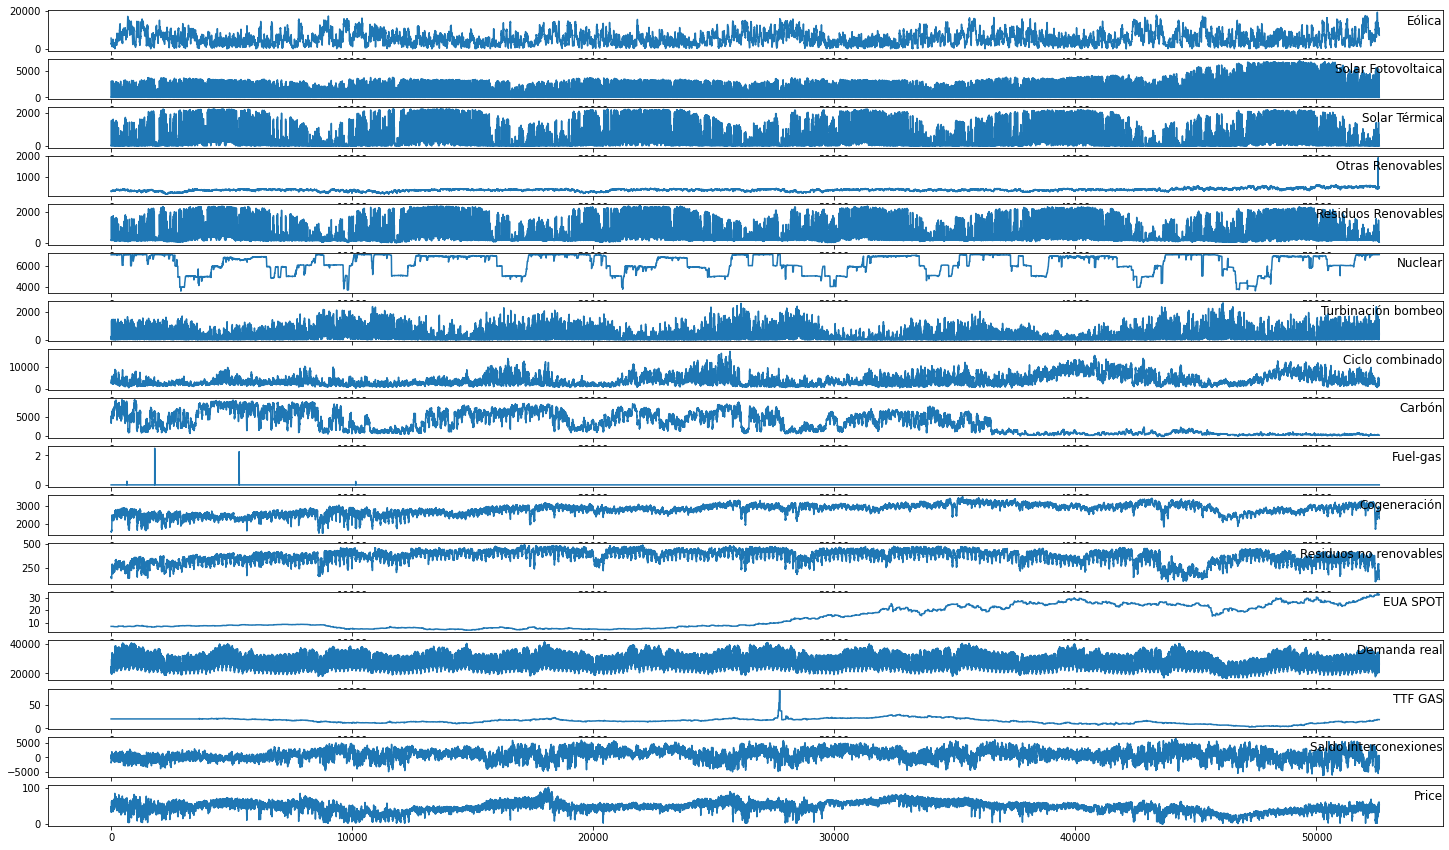

In [66]:
values = df.values

groups = range(1,len(df.columns))
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
    
plt.show()

In [67]:
df.describe()
#Raro, valores negativos en Solar Fotovoltaica.
#Otras renovables tiene un pico final demasiado elevado, hay que normalizarlo.
#El pico que se produce en el precio del gas, se produjo cuando la OPEC disminuyo la producción de petroleo.

#Fuel-gas es una columna a eliminar ya que solo aporta ruido
#El Carbon se deja de utilizar a partir de 2018.
#El precio del CO2 aumenta con el tiempo.

,Hidráulica,Eólica,Solar Fotovoltaica,Solar Térmica,Otras Renovables,Residuos Renovables,Nuclear,Turbinación bombeo,Ciclo combinado,Carbón,Fuel-gas,Cogeneración,Residuos no renovables,EUA SPOT,Demanda real,TTF GAS,Saldo Interconexiones,Price
count,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000,52606.000000
mean,3276.598966,5671.714148,1037.299994,563.309163,419.349151,719.885205,6291.815312,278.791927,3802.618201,3393.793867,0.000320,2775.176291,363.660368,14.068794,28392.095667,16.020454,721.191102,46.851637
std,1884.451678,3371.552853,1435.395539,696.892405,63.015837,694.696615,873.714141,363.349254,2548.191581,2623.697526,0.025201,306.625001,69.252429,8.748208,4622.648607,5.452242,1733.110514,14.760716
min,31.861000,127.783000,-0.638000,0.000000,211.789000,27.655000,3563.188000,-3.777000,244.223000,-62.132000,-0.001000,1437.607000,103.552000,3.930000,16542.500000,2.900000,-6296.110000,0.030000
25%,1785.527000,3023.688750,0.229000,10.562000,387.528250,191.044750,5872.791500,12.494250,1920.063750,872.208750,0.000000,2586.584500,325.014000,6.062500,24523.125000,12.325000,-387.738250,38.090000
50%,2889.153000,5024.031000,41.585000,223.430000,420.524500,378.279500,6740.691500,137.870000,2937.543000,2915.269500,0.000000,2820.614000,373.104000,8.580000,28498.333333,16.100000,792.288000,47.815000
75%,4442.798000,7685.273000,2024.712750,880.088750,446.601250,1036.084000,7041.385500,401.560000,5085.159750,5793.750500,0.000000,2998.030750,418.430000,23.490000,31933.625000,20.275000,1900.631750,56.920000
max,10271.723000,19377.079000,6957.408000,2206.026000,1919.574000,2397.105000,7144.021000,2683.276000,16948.276000,9257.092000,2.493000,3544.117000,488.824000,33.290000,41073.666667,81.000000,6423.820000,101.990000


# **Data Cleaning**

Corregimos los valores negativos de la columna Solar Fotovoltaica

In [68]:
#300 valores en de Solar Fotovoltaica que son 0 cuando normalmente tienen un valor pequeño pero nunca negativo
#Solucion los igualamos todos a 0
df[(df['Solar Fotovoltaica']<0)]['Solar Fotovoltaica'].shape

(300,)

In [69]:
index = df[(df['Solar Fotovoltaica']<0)]['Solar Fotovoltaica'].index

df.loc[index,'Solar Fotovoltaica'] = 0

In [70]:
df[df['Otras Renovables'] == df['Otras Renovables'].max()]

,Hidráulica,Eólica,Solar Fotovoltaica,Solar Térmica,Otras Renovables,Residuos Renovables,Nuclear,Turbinación bombeo,Ciclo combinado,Carbón,Fuel-gas,Cogeneración,Residuos no renovables,EUA SPOT,Demanda real,TTF GAS,Saldo Interconexiones,Price
datetime,,,,,,,,,,,,,,,,,,
2020-12-30 03:00:00+00:00,2997.332,11116.453,0.224,15.49,1919.574,173.571,7122.144,-2.298,2166.534,232.849,0.0,2764.626,229.986,32.02,21122.166667,19.15,-4642.08,33.5


Hay un outlier bastante sospechoso en Otras Renovables

In [71]:
df[df.index > '2020-12-30']['Otras Renovables'].head(10)

datetime
2020-12-30 00:00:00+00:00     507.553
2020-12-30 01:00:00+00:00     508.977
2020-12-30 02:00:00+00:00     508.322
2020-12-30 03:00:00+00:00    1919.574
2020-12-30 04:00:00+00:00     497.199
2020-12-30 05:00:00+00:00     505.051
2020-12-30 06:00:00+00:00     507.204
2020-12-30 07:00:00+00:00     500.316
2020-12-30 08:00:00+00:00     505.860
2020-12-30 09:00:00+00:00     514.070
Name: Otras Renovables, dtype: float64

In [72]:
#Lo reemplazamos con la media de los valores inmediatamente antes y despues-

index = df[df['Otras Renovables'] == df['Otras Renovables'].max()].index

df.loc[index,'Otras Renovables'] = (497.199 + 508.322)/2


Hay otro outlier en el TTF GAS

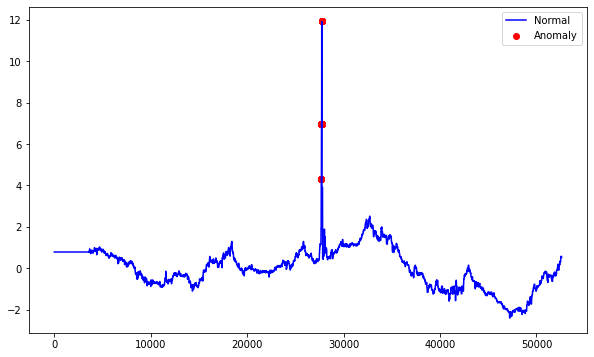

In [73]:
#Fue un pico del gas que duro durante varios dias. Se detectan los puntos con isolation forest.

#Encontramos los puntos del pico y los visualizamos

data = df['TTF GAS'].values.reshape([-1,1])
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, columns = ['TTF GAS'])
# train isolation forest
model =  IsolationForest(contamination=0.0025)
model.fit(data) 
data['anomaly'] = pd.Series(model.predict(data))

#Visualization
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly'] == -1, 'TTF GAS']

ax.plot(data['TTF GAS'].index , data['TTF GAS'], color='blue', label = 'Normal')
ax.scatter( a.index, a.values, color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [74]:
data[data['anomaly']==-1].index

Int64Index([27672, 27673, 27674, 27675, 27676, 27677, 27678, 27679, 27680,
            27681, 27682, 27683, 27684, 27685, 27686, 27687, 27688, 27689,
            27690, 27691, 27692, 27693, 27694, 27695, 27696, 27697, 27698,
            27699, 27700, 27701, 27702, 27703, 27704, 27705, 27706, 27707,
            27708, 27709, 27710, 27711, 27712, 27713, 27714, 27715, 27716,
            27717, 27718, 27719, 27720, 27721, 27722, 27723, 27724, 27725,
            27726, 27727, 27728, 27729, 27730, 27731, 27732, 27733, 27734,
            27735, 27736, 27737, 27738, 27739, 27740, 27741, 27742, 27743],
           dtype='int64')

In [75]:
#Ya que el pico realmente existio, por una anomalia en el mercado lo suavizamos para que no afecte tanto sobre el modelo
df.iloc[27672:27744,-3] = 39.5 

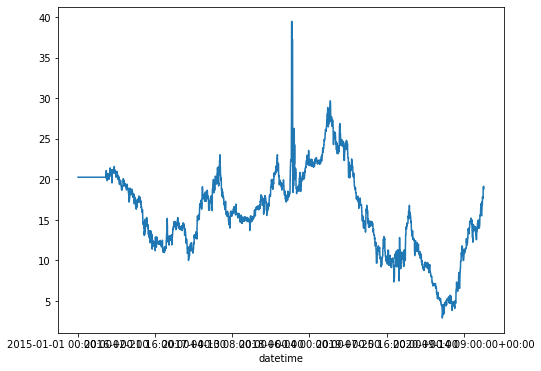

In [76]:
df['TTF GAS'].plot()

In [77]:
#Nos cargamos columnas
#Hay columnas que no se consideran relevantes ya que aportan poco informacion al modelo y solo general ruido
#Por eso borramos Fuel-gas, Otras Renovables, Residuos no renovables,	Residuos renovables

df.drop(columns=['Fuel-gas', 'Otras Renovables', 'Residuos no renovables', 'Residuos Renovables'],axis=1,inplace=True)

# **Preprocessing**

In [252]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#Asignamos el 70% de los datos al train dataset
train_df = df[0:int(n*0.7)]
#Asignamos el 20% de los datos al validation dataset
val_df = df[int(n*0.7):int(n*0.9)]
#Asignamos el 20% de los datos al test dataset
test_df = df[int(n*0.9):]

#Cuantas features en total tiene nuestro data set
columns = train_df.columns
num_features = df.shape[1]

In [253]:
trans = MinMaxScaler()
data = trans.fit_transform(train_df)
train_df = pd.DataFrame(data, columns = columns)

data = trans.transform(val_df)
val_df = pd.DataFrame(data, columns = columns)

data = trans.transform(test_df)
test_df = pd.DataFrame(data, columns = columns)

# **Data Wrangling**

In [80]:
#Clase a la que se le introducen los 3 datasets y los tamaños de nuestras ventanas
#Convierte los dataset al formato y los separa en inputs y labels tanto para el train, validation y test
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    #Esta funcion coge los dataset que se la pasan y los convierte al formato tf.data.Dataset
    #Crea secuencias del dataset. Las secuencias se iran desplanzando de hora en hora: 1ª [1,2,3,4,5], 2º [2,3,4,5,6], 3ª [3,4,5,6,7] ...
    def make_dataset(self, data):
        data = np.array(data, dtype=float)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size, #Le pasamos el tamaño de la ventana, es decir de cuantas horas totales se ha de componer cada ventana.
          sequence_stride=1,
          shuffle=True, #Aqui se le indica si queremos que mezcle las secuencias o que mantenga el orden en que se le van pasanndo #Alberto ¿Que es mejor para modelar?
          batch_size=32) #Batch size es el tamaño de agrupamiento de las secuencias que va generando. 32 es el tamaño optimo recomendado en machine learning.

          #A priorri true para eliminar correlaciones temporales
          
        ds = ds.map(self.split_window)#Separamos el dataset en dos, inputs y labels (Xs e Ys)

        return ds

    #Esta funcion separa las variables dependientes Y de las independientes X
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='Price', max_subplots=9):

        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time [h]')

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

In [81]:
OUT_STEPS = 24

#Generamos una ventana para los datos de 168 horas (7 dias) de inputs mas 24 horas de dias para predecir
multi_window = WindowGenerator(input_width=168, label_width=24, shift=OUT_STEPS, label_columns=['Price'])

multi_window

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['Price']

In [83]:
print('Input shape:', multi_window.example[0].shape)
print('Label shape:', multi_window.example[1].shape)

Input shape: (32, 168, 14)
Label shape: (32, 24, 1)


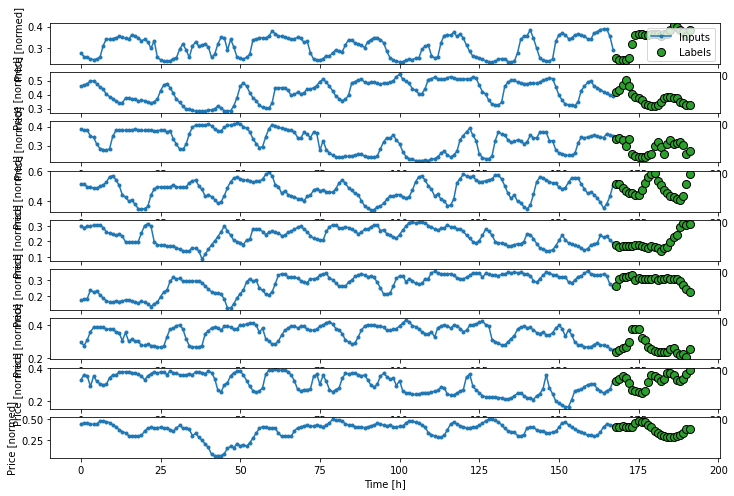

In [84]:
multi_window.plot()

# **Modeling**

## Multi dense

In [85]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=24),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([-1, 1]),
])

In [86]:
history = compile_and_fit(multi_step_dense, multi_window)

Epoch 1/20
1145/1145 [==============================] - 12s 10ms/step - loss: 0.0117 - mean_absolute_error: 0.0729 - val_loss: 0.0044 - val_mean_absolute_error: 0.0507
Epoch 2/20
1145/1145 [==============================] - 9s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0539 - val_loss: 0.0035 - val_mean_absolute_error: 0.0452
Epoch 3/20
1145/1145 [==============================] - 11s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0517 - val_loss: 0.0035 - val_mean_absolute_error: 0.0449
Epoch 4/20
1145/1145 [==============================] - 8s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0509 - val_loss: 0.0055 - val_mean_absolute_error: 0.0576
Epoch 5/20
1145/1145 [==============================] - 10s 9ms/step - loss: 0.0043 - mean_absolute_error: 0.0495 - val_loss: 0.0033 - val_mean_absolute_error: 0.0443
Epoch 6/20
1145/1145 [==============================] - 14s 12ms/step - loss: 0.0041 - mean_absolute_error: 0.0479 - val_loss: 0.0037 - val_mean_absolute_error: 0.046

In [87]:
multi_step_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                75296     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
reshape (Reshape)            (None, 24, 1)             0         
Total params: 77,144
Trainable params: 77,144
Non-trainable params: 0
_________________________________________________________________


In [88]:
multi_step_dense(multi_window.example[0]).shape

TensorShape([32, 24, 1])

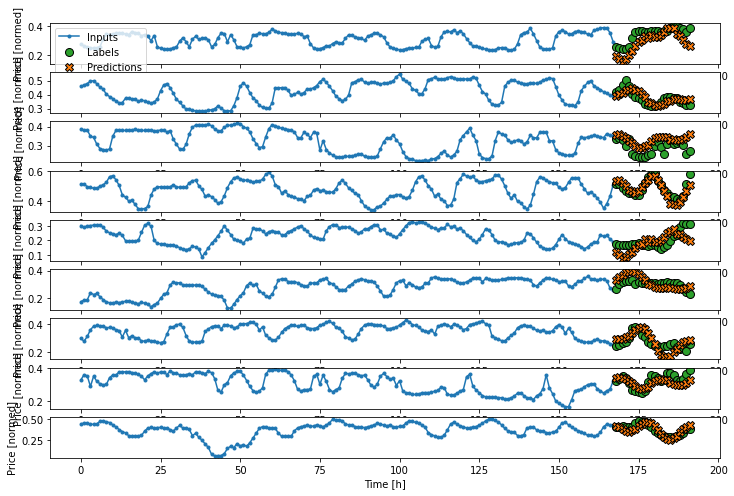

In [89]:
multi_window.plot(multi_step_dense)


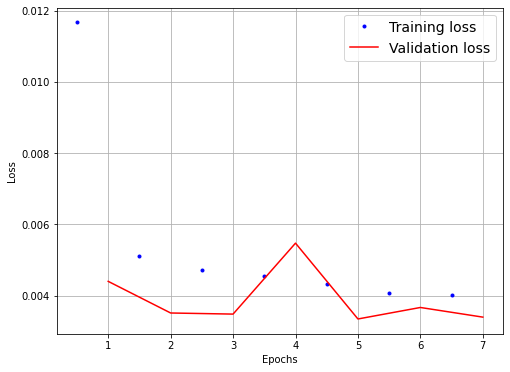

In [90]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [91]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(multi_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0444


## Single-Step CNN

In [92]:
CONV_WIDTH = 168 #Input with

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=24),
    tf.keras.layers.Reshape([-1, 1]),
])

In [93]:
history = compile_and_fit(conv_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 9s 7ms/step - loss: 0.0127 - mean_absolute_error: 0.0752 - val_loss: 0.0043 - val_mean_absolute_error: 0.0495
Epoch 2/20
1145/1145 [==============================] - 9s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0541 - val_loss: 0.0036 - val_mean_absolute_error: 0.0465
Epoch 3/20
1145/1145 [==============================] - 9s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0483 - val_loss: 0.0044 - val_mean_absolute_error: 0.0516
Epoch 4/20
1145/1145 [==============================] - 11s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0463 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441
Epoch 5/20
1145/1145 [==============================] - 9s 8ms/step - loss: 0.0038 - mean_absolute_error: 0.0460 - val_loss: 0.0034 - val_mean_absolute_error: 0.0453
Epoch 6/20
1145/1145 [==============================] - 10s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0453 - val_loss: 0.0032 - val_mean_absolute_error: 0.0436
Ep

In [94]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             75296     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 24)             792       
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 1)             0         
Total params: 77,144
Trainable params: 77,144
Non-trainable params: 0
_________________________________________________________________


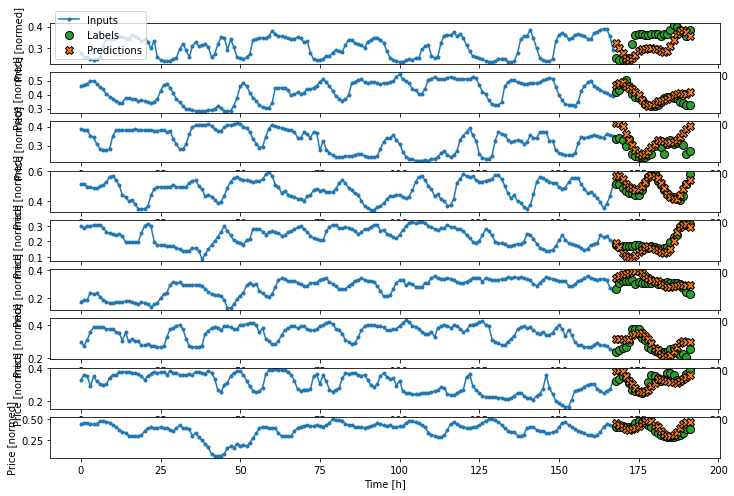

In [95]:
multi_window.plot(conv_model)

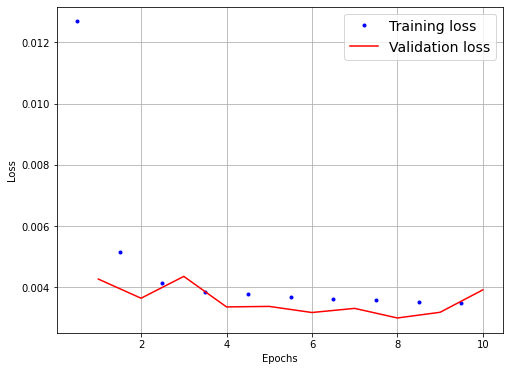

In [96]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [97]:
val_performance['CONV'] = conv_model.evaluate(multi_window.val)
performance['CONV'] = conv_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 5ms/step - loss: 0.0039 - mean_absolute_error: 0.0483


## Single-step RNN

In [126]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=24),
    tf.keras.layers.Reshape([-1, 1]), 
])

In [127]:
history = compile_and_fit(lstm_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 160s 138ms/step - loss: 0.0080 - mean_absolute_error: 0.0638 - val_loss: 0.0058 - val_mean_absolute_error: 0.0576
Epoch 2/20
1145/1145 [==============================] - 147s 129ms/step - loss: 0.0041 - mean_absolute_error: 0.0475 - val_loss: 0.0064 - val_mean_absolute_error: 0.0616
Epoch 3/20
1145/1145 [==============================] - 98s 86ms/step - loss: 0.0036 - mean_absolute_error: 0.0442 - val_loss: 0.0046 - val_mean_absolute_error: 0.0503
Epoch 4/20
1145/1145 [==============================] - 144s 126ms/step - loss: 0.0033 - mean_absolute_error: 0.0426 - val_loss: 0.0044 - val_mean_absolute_error: 0.0498
Epoch 5/20
1145/1145 [==============================] - 111s 97ms/step - loss: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0039 - val_mean_absolute_error: 0.0466
Epoch 6/20
1145/1145 [==============================] - 104s 91ms/step - loss: 0.0030 - mean_absolute_error: 0.0404 - val_loss: 0.0038 - val_mean_absolut

In [128]:
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                20224     
_________________________________________________________________
dense_12 (Dense)             (None, 24)                1560      
_________________________________________________________________
reshape_5 (Reshape)          (None, 24, 1)             0         
Total params: 21,784
Trainable params: 21,784
Non-trainable params: 0
_________________________________________________________________


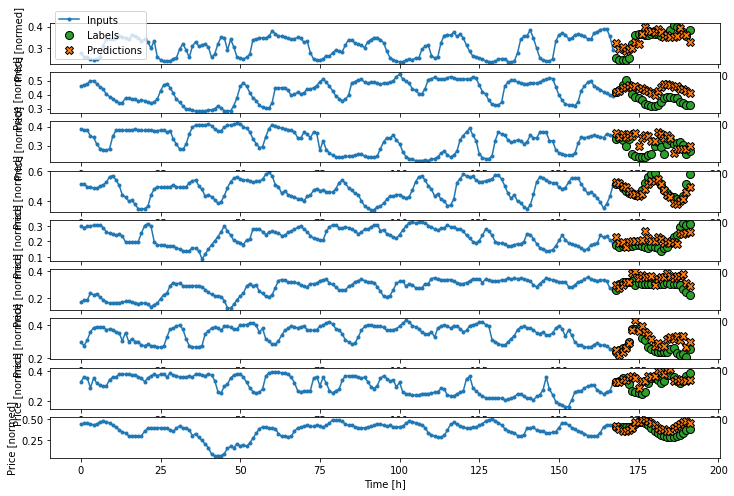

In [129]:
multi_window.plot(lstm_model)


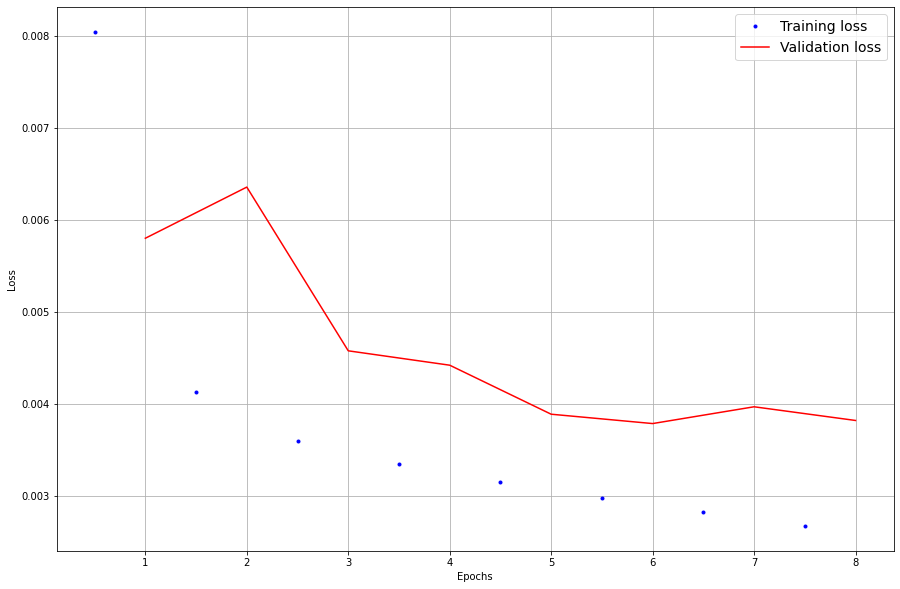

In [130]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [131]:
val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 8s 25ms/step - loss: 0.0038 - mean_absolute_error: 0.0460


## Multi-Step CNN

In [104]:
CONV_WIDTH = 168

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [105]:
history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 18s 15ms/step - loss: 0.0075 - mean_absolute_error: 0.0648 - val_loss: 0.0040 - val_mean_absolute_error: 0.0482
Epoch 2/20
1145/1145 [==============================] - 17s 15ms/step - loss: 0.0056 - mean_absolute_error: 0.0575 - val_loss: 0.0048 - val_mean_absolute_error: 0.0522
Epoch 3/20
1145/1145 [==============================] - 17s 15ms/step - loss: 0.0053 - mean_absolute_error: 0.0559 - val_loss: 0.0046 - val_mean_absolute_error: 0.0509


In [106]:
multi_conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 168, 14)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 256)            602368    
_________________________________________________________________
dropout (Dropout)            (None, 1, 256)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1, 24)             6168      
_________________________________________________________________
reshape_3 (Reshape)          (None, 24, 1)             0         
Total params: 608,536
Trainable params: 608,536
Non-trainable params: 0
_________________________________________________________________


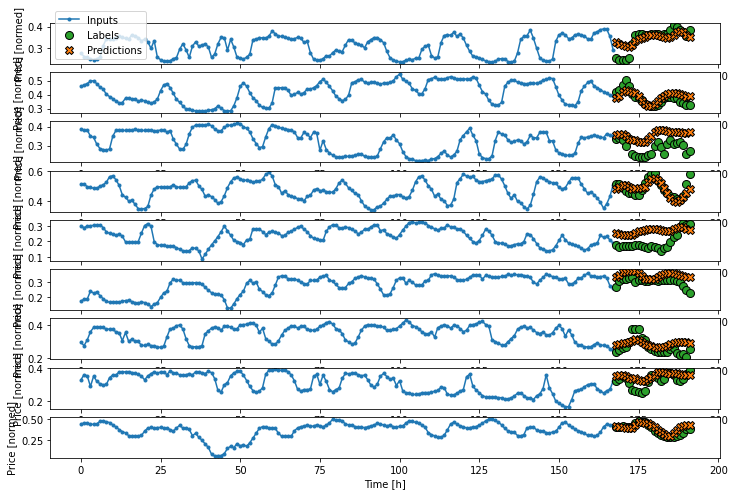

In [107]:
multi_window.plot(multi_conv_model)

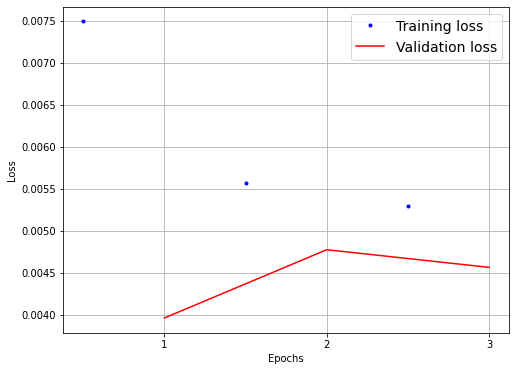

In [108]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [109]:
val_performance['MULTI_CONV'] = multi_conv_model.evaluate(multi_window.val)
performance['MULTI_CONV'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 2s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0509


## Multi-step RNN

In [110]:
multi_lstm_model = tf.keras.Sequential([
                                        
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUT_STEPS*1,),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [111]:
history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/20
1145/1145 [==============================] - 104s 89ms/step - loss: 0.0143 - mean_absolute_error: 0.0881 - val_loss: 0.0071 - val_mean_absolute_error: 0.0648
Epoch 2/20
1145/1145 [==============================] - 99s 86ms/step - loss: 0.0063 - mean_absolute_error: 0.0606 - val_loss: 0.0055 - val_mean_absolute_error: 0.0559
Epoch 3/20
1145/1145 [==============================] - 102s 89ms/step - loss: 0.0048 - mean_absolute_error: 0.0519 - val_loss: 0.0054 - val_mean_absolute_error: 0.0540
Epoch 4/20
1145/1145 [==============================] - 98s 86ms/step - loss: 0.0042 - mean_absolute_error: 0.0484 - val_loss: 0.0059 - val_mean_absolute_error: 0.0577
Epoch 5/20
1145/1145 [==============================] - 100s 87ms/step - loss: 0.0038 - mean_absolute_error: 0.0460 - val_loss: 0.0049 - val_mean_absolute_error: 0.0525
Epoch 6/20
1145/1145 [==============================] - 99s 87ms/step - loss: 0.0036 - mean_absolute_error: 0.0445 - val_loss: 0.0047 - val_mean_absolute_err

In [112]:
multi_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                20224     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1560      
_________________________________________________________________
reshape_4 (Reshape)          (None, 24, 1)             0         
Total params: 21,784
Trainable params: 21,784
Non-trainable params: 0
_________________________________________________________________


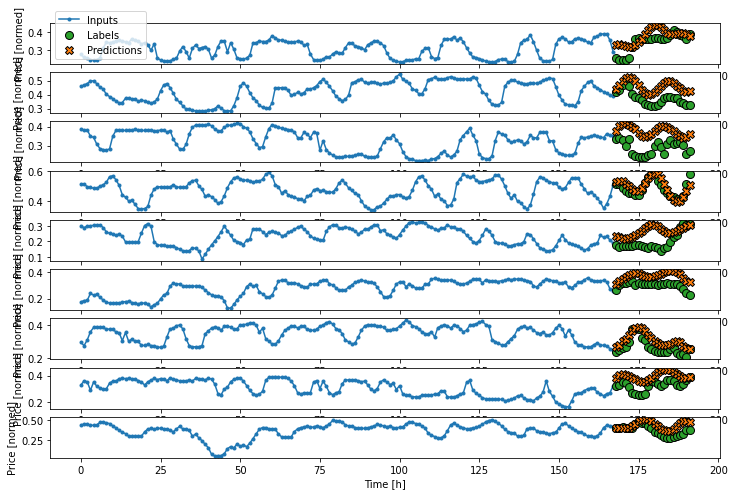

In [113]:
multi_window.plot(multi_lstm_model)

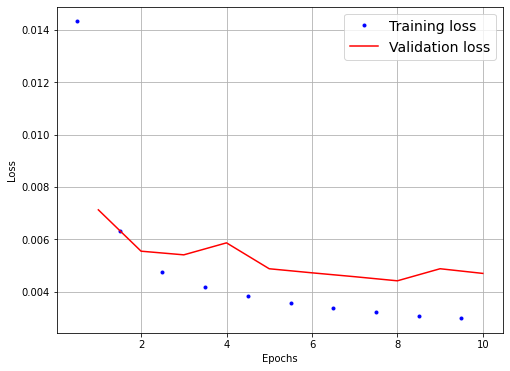

In [114]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [115]:
val_performance['MULTI_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['MULTI_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 12s 37ms/step - loss: 0.0047 - mean_absolute_error: 0.0514


## Encoder-Decoder LSTM 

In [118]:
EDLSTM = tf.keras.models.Sequential([                     
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(168, num_features)),
    tf.keras.layers.RepeatVector(24),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
    ])

In [119]:
history = compile_and_fit(EDLSTM, multi_window)

Epoch 1/20
1145/1145 [==============================] - 151s 128ms/step - loss: 0.0103 - mean_absolute_error: 0.0757 - val_loss: 0.0059 - val_mean_absolute_error: 0.0591
Epoch 2/20
1145/1145 [==============================] - 138s 120ms/step - loss: 0.0068 - mean_absolute_error: 0.0632 - val_loss: 0.0062 - val_mean_absolute_error: 0.0613
Epoch 3/20
1145/1145 [==============================] - 144s 125ms/step - loss: 0.0055 - mean_absolute_error: 0.0564 - val_loss: 0.0071 - val_mean_absolute_error: 0.0656


In [120]:
EDLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                13000     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 25)            1275      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             26        
Total params: 34,501
Trainable params: 34,501
Non-trainable params: 0
__________________________________________________

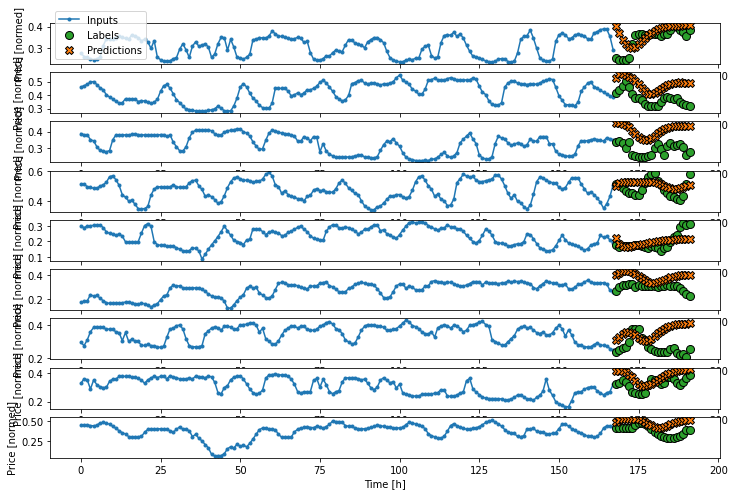

In [121]:
multi_window.plot(EDLSTM)

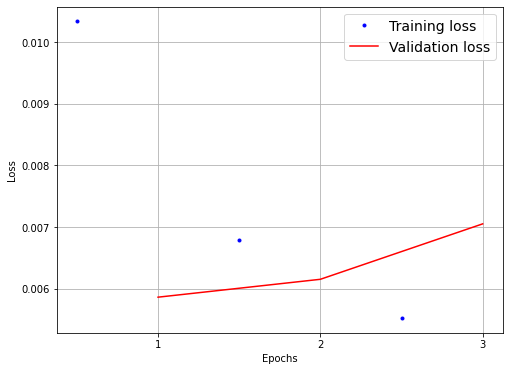

In [122]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [123]:
val_performance['EndDedLSTM'] = EDLSTM.evaluate(multi_window.val)
performance['EndDedLSTM'] = EDLSTM.evaluate(multi_window.test, verbose=0)

323/323 [==============================] - 8s 26ms/step - loss: 0.0071 - mean_absolute_error: 0.0656


# **Evaluation**

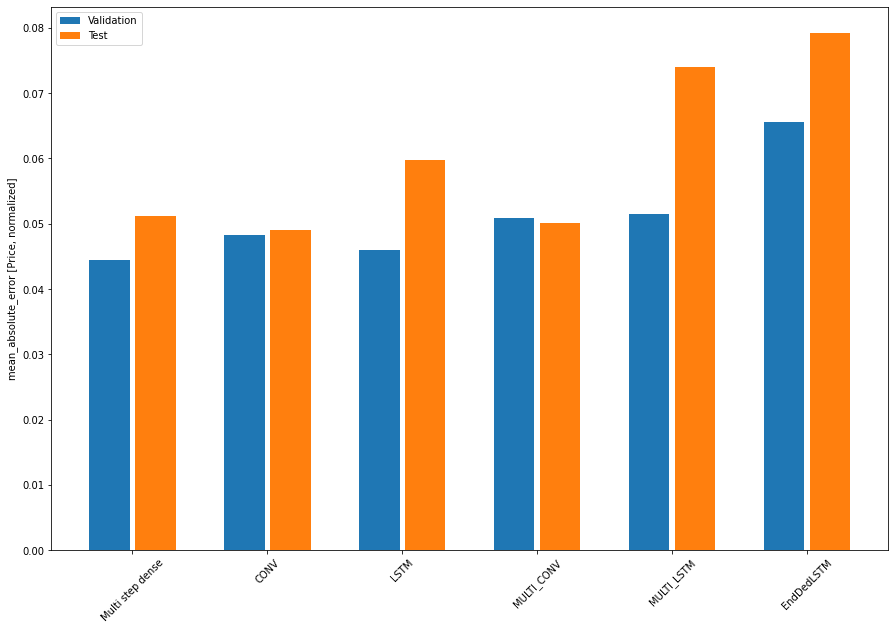

In [135]:
#Ploteamos la performance de los diferentes modelos
mpl.rcParams['figure.figsize'] = (15, 10)

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [134]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Multi step dense: 0.0512
CONV        : 0.0490
LSTM        : 0.0597
MULTI_CONV  : 0.0502
MULTI_LSTM  : 0.0741
EndDedLSTM  : 0.0793


# **Predictions**

In [255]:
 test = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/inputs.xlsx', header=None)


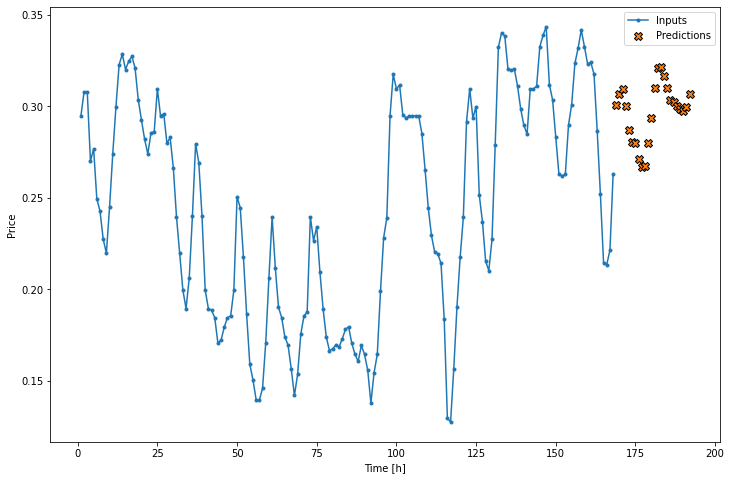

In [346]:
#Visualizar prediccion
plt.figure(figsize=(12, 8))

input_test = trans.transform(np.array(test_df.iloc[336:504,:]))

plt.plot(np.arange(1,169), input_test[:,13], label='Inputs', marker='.', zorder=-10) 

label_predictions = multi_conv_model(np.expand_dims(input_test, axis=0))

plt.scatter(np.arange(169,193), label_predictions[0,:,0], marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

plt.ylabel('Price')
plt.legend()
plt.xlabel('Time [h]');

In [344]:
label_predictions

<tf.Tensor: shape=(1, 24, 1), dtype=float32, numpy=
array([[[0.30087954],
        [0.30687153],
        [0.30929643],
        [0.30014682],
        [0.28698045],
        [0.28025347],
        [0.28021795],
        [0.2712237 ],
        [0.26667807],
        [0.2672885 ],
        [0.28013444],
        [0.2934996 ],
        [0.3098572 ],
        [0.32102865],
        [0.3214927 ],
        [0.31682053],
        [0.31028187],
        [0.30371568],
        [0.30246252],
        [0.3001352 ],
        [0.29847723],
        [0.29765177],
        [0.2998585 ],
        [0.30686927]]], dtype=float32)>